In [2]:
%matplotlib inline
from config import pword
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# from config import password 

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
spark = SparkSession.builder.appName('pyspark_app') \
.config('spark.driver.extraClassPath','postgresql-42.2.11') \
.master('local[*]') \
.getOrCreate()


In [5]:
from pyspark import SparkFiles
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round, col

In [6]:
#path for video games
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz"
#path for toys
# url2 = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz"

In [7]:
#add url file
spark.sparkContext.addFile(url)

In [8]:
df = spark.read.option("header", "true").csv(SparkFiles.get
                                             ("amazon_reviews_us_Video_Games_v1_00.tsv.gz"), inferSchema=True, sep='\t')

In [9]:
print(f'There are {df.count()} rows in the video game dataframe')

There are 1785997 rows in the video game dataframe


In [10]:
#create column in correct date format
df = df.withColumn("date", to_date(df['review_date']))

In [11]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)
 |-- date: date (nullable = true)



In [141]:
#create reviews df
review_df = df.select(["review_id", "customer_id", "product_id", "product_parent", "date"])
review_df.show(5)

+--------------+-----------+----------+--------------+----------+
|     review_id|customer_id|product_id|product_parent|      date|
+--------------+-----------+----------+--------------+----------+
| RTIS3L2M1F5SM|   12039526|B001CXYMFS|     737716809|2015-08-31|
| R1ZV7R40OLHKD|    9636577|B00M920ND6|     569686175|2015-08-31|
|R3BH071QLH8QMC|    2331478|B0029CSOD2|      98937668|2015-08-31|
|R127K9NTSXA2YH|   52495923|B00GOOSV98|      23143350|2015-08-31|
|R32ZWUXDJPW27Q|   14533949|B00Y074JOM|     821342511|2015-08-31|
+--------------+-----------+----------+--------------+----------+
only showing top 5 rows



In [148]:
review_df = review_df.filter(review_df['date'].isNotNull())
review_df = review_df.orderBy(review_df['date'].asc())
review_df.show()

+--------------+-----------+----------+--------------+----------+
|     review_id|customer_id|product_id|product_parent|      date|
+--------------+-----------+----------+--------------+----------+
| R85QTDO2KZMGO|   53088309|B00000JL6V|     334018759|1997-11-06|
|R2W36RZZZNTYWF|   52917144|B00000JL6V|     334018759|1997-11-06|
| RJ5BETZP0VIUS|   53023047|B00000JL6V|     334018759|1997-11-08|
| RPC430LWZJ60T|   52758880|B00000JL6V|     334018759|1997-11-09|
|R347MZT5FH6HRJ|   52477491|B00000JL6V|     334018759|1997-11-09|
|R3C8YZ5PVHS0FV|   52958893|B00000JL6V|     334018759|1997-11-18|
|R2HRHSLRKZZVNJ|   52930256|B00000JL6V|     334018759|1997-11-29|
|R2N4VCBGD3NSZE|   52827638|B00000JL6V|     334018759|1997-12-08|
|R1U4NAKFZRFFLA|   53068113|B00000JL6V|     334018759|1997-12-13|
| RT1RXAF0JRS9U|   52714368|B00000JL6V|     334018759|1997-12-14|
|R106WHTX7V70A9|   52883365|B00000JL6V|     334018759|1997-12-17|
|R1GX13TWPZ910P|   52936386|B00000JL6V|     334018759|1997-12-18|
| RZWFMQAT

In [13]:
#create customer df with unique custy id
custy_df = df.groupBy('customer_id').count()

In [14]:
#rename count col
custy_df = custy_df.withColumnRenamed('count','customer_count')

In [15]:
custy_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   48670265|             1|
|   49103216|             2|
|    1131200|             1|
|   43076447|             2|
|   46261368|             1|
+-----------+--------------+
only showing top 5 rows



In [16]:
#create prod df with unique prod id
prod_df = df.select(["product_id", "product_title"])
prod_df = prod_df.dropDuplicates(['product_id'])

In [17]:
prod_df.count()

65792

In [159]:
#create vine df
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine"])
vine_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
| RTIS3L2M1F5SM|          5|            0|          0|   N|
| R1ZV7R40OLHKD|          5|            0|          0|   N|
|R3BH071QLH8QMC|          1|            0|          1|   N|
|R127K9NTSXA2YH|          3|            0|          0|   N|
|R32ZWUXDJPW27Q|          4|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [19]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://big-data-2.cpclfqan17p9.us-east-1.rds.amazonaws.com:5432/bd-homework"
config = {"user":"postgres", 
          "password": pword, 
          "driver":"org.postgresql.Driver"}

In [21]:
#write reviews to RDS
review_df.write.jdbc(url=jdbc_url, table='review_id_table', mode=mode, properties=config)

In [ ]:
#write customers
custy_df.write.jdbc(url=jdbc_url, table='customers', mode=mode, properties=config)

In [39]:
#write products
prod_df.write.jdbc(url=jdbc_url, table='products', mode=mode, properties=config)

In [40]:
#write vine
vine_df.write.jdbc(url=jdbc_url, table='vine_table', mode=mode, properties=config)

In [166]:
#create function to run analysis on reviews in ("Y") and out of ("N") vine program 
def vine_program(yes_no):
    #dopr all rows that have no votes
    filter_df = vine_df.filter(vine_df["total_votes"]>0)
    df = filter_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').count()
    #rename count col
    df = df.withColumnRenamed('count','star_count')
    #count vine reviews
    total = df.groupBy().sum('star_count').collect()[0][0]
    print(f'There are {total} reviews with vine marker {yes_no} and at least one vote')
    #create percent of total column
    df = df.withColumn('star_pct',round(df['star_count']/total,4))
    #get total number of helpful votes by star rating
    df_help = vine_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').agg(sum('helpful_votes'),sum('total_votes'))
    #rename helpful votes col
    df_help = df_help.withColumnRenamed('sum(helpful_votes)', 'helpful_votes').withColumnRenamed('sum(total_votes)',
                                                                                                 'total_votes')
    #join helpful votes to vine ratings
    df = df.join(df_help,['star_rating'])
    #create column which averages # of helpful votes by star
    df = df.withColumn('helpful_avg',round(df['helpful_votes']/df['star_count'],4))
    df = df.withColumn('helpful_ratio',round(df['helpful_votes']/df['total_votes'],4))
    #count reviews by star that have no helpful votes
#     no_help_df = vine_df.filter(vine_df["vine"]==yes_no).filter(vine_df['helpful_votes']==0).groupBy('star_rating').count()
#     #rename count column
#     no_help_df = no_help_df.withColumnRenamed('count', 'rvws_no_helpfuls')
#     #join no_help df to df
#     df = df.join(no_help_df,['star_rating'])
#     #calcualte pct of reviews with no helpful votes
#     df = df.withColumn('pct_no_help',round(df['rvws_no_helpfuls']/df['star_count'],4))
    #order by star rating
    df = df.orderBy(df['star_rating'].asc())
    #show schema
    df.printSchema()
    global pandas_df
    pandas_df = df.toPandas()
    if yes_no == "Y":
        color = "blue"
        title = "Vine"
    else:
        color = "red"
        title = "Non-Vine"
        
    #plot number of reviews by star rating
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['star_pct'], color =color)
    plt.title(f"{title} Reviews", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("% of Ratings", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}reviews.png")
    #plot average of helpful votes per review by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['helpful_avg'], color =color)
    plt.title(f"Avg # of Helpful Votes per {title} Review", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Average", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}_help_avg.png")
    #plot helpful vote ratio by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['helpful_ratio'], color =color)
    plt.title(f"Helpful Vote Ratio for {title} Reviews", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Percent", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"{title}_ratio.png")
    #save pandas_df as csv
    pandas_df.to_csv(f"{yes_no}_summary", index=False)
    return df.show()
    
    

There are 2572 reviews with vine marker Y
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- helpful_ratio: double (nullable = true)

+-----------+----------+--------+-------------+-----------+-----------+-------------+
|star_rating|star_count|star_pct|helpful_votes|total_votes|helpful_avg|helpful_ratio|
+-----------+----------+--------+-------------+-----------+-----------+-------------+
|          1|        51|  0.0198|          103|        313|     2.0196|       0.3291|
|          2|       146|  0.0568|          448|        826|     3.0685|       0.5424|
|          3|       456|  0.1773|         1419|       2267|     3.1118|       0.6259|
|          4|       961|  0.3736|         3862|       5068|     4.0187|        0.762|
|          5|       958|  0.3725|         4245|      

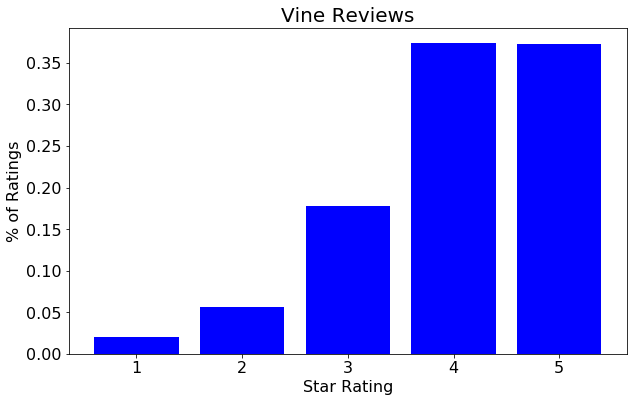

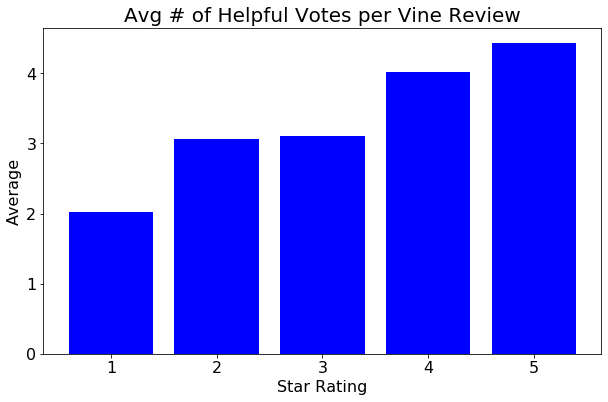

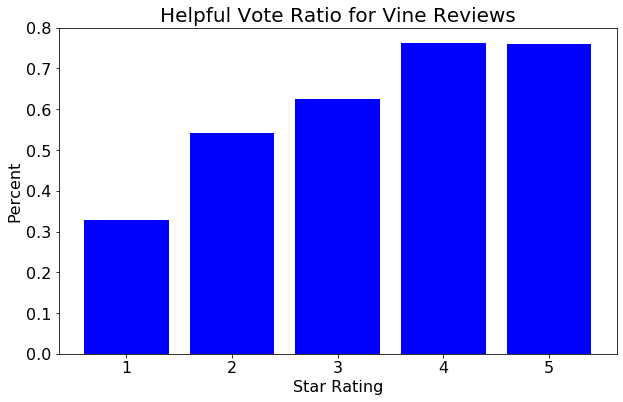

In [165]:
vine_program("Y")

There are 903896 reviews with vine marker N and at least one vote
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- helpful_ratio: double (nullable = true)

+-----------+----------+--------+-------------+-----------+-----------+-------------+
|star_rating|star_count|star_pct|helpful_votes|total_votes|helpful_avg|helpful_ratio|
+-----------+----------+--------+-------------+-----------+-----------+-------------+
|          1|    151702|  0.1678|       911501|    2057975|     6.0085|       0.4429|
|          2|     67823|   0.075|       310776|     564850|     4.5822|       0.5502|
|          3|     93924|  0.1039|       408177|     657029|     4.3458|       0.6212|
|          4|    159358|  0.1763|       687691|     954416|     4.3154|       0.7205|
|          5|    431089|  0.4

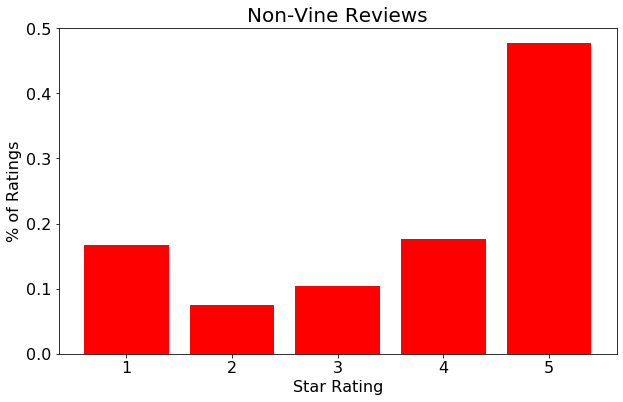

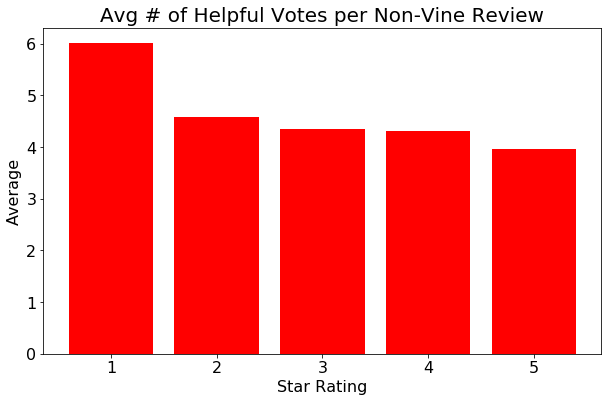

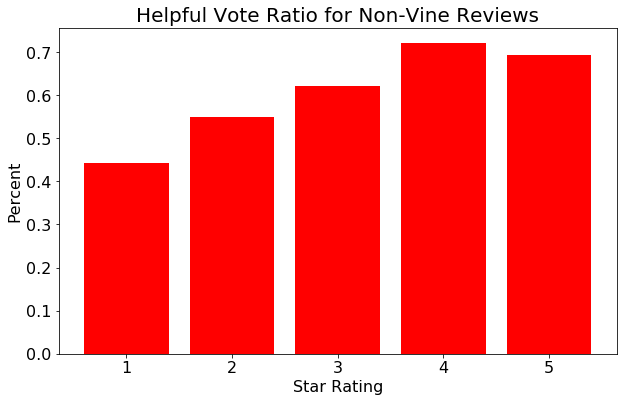

In [167]:
vine_program("N")

In [168]:
pandas_df

,star_rating,star_count,star_pct,helpful_votes,total_votes,helpful_avg,helpful_ratio
0,1,151702,0.1678,911501,2057975,6.0085,0.4429
1,2,67823,0.0750,310776,564850,4.5822,0.5502
2,3,93924,0.1039,408177,657029,4.3458,0.6212
3,4,159358,0.1763,687691,954416,4.3154,0.7205
4,5,431089,0.4769,1706969,2462313,3.9597,0.6932


In [172]:
cust_check_df =  df.select(["customer_id", "star_rating", "helpful_votes", "total_votes", "vine"])
cust_check_df = cust_check_df.filter(cust_check_df['vine'] == 'Y').filter(cust_check_df['total_votes']>0)

In [173]:
cust_check_df.show(5)

+-----------+-----------+-------------+-----------+----+
|customer_id|star_rating|helpful_votes|total_votes|vine|
+-----------+-----------+-------------+-----------+----+
|   12113794|          4|            2|          4|   Y|
|   39916916|          1|            1|          2|   Y|
|   42689422|          4|            1|          2|   Y|
|   20981134|          5|            1|          2|   Y|
|   50398454|          5|            3|          4|   Y|
+-----------+-----------+-------------+-----------+----+
only showing top 5 rows



In [174]:
from pyspark.sql.functions import count, avg, sum

In [175]:
group_cust_df = cust_check_df.groupBy("customer_id").agg(count("customer_id"),avg("star_rating"), sum("helpful_votes"), sum("total_votes"))

In [176]:
group_cust_df.show(5)

+-----------+------------------+-----------------+------------------+----------------+
|customer_id|count(customer_id)| avg(star_rating)|sum(helpful_votes)|sum(total_votes)|
+-----------+------------------+-----------------+------------------+----------------+
|   17481726|                 7|3.857142857142857|                31|              43|
|   22978817|                 1|              5.0|                 1|               7|
|   49214860|                 1|              3.0|                 4|               6|
|   52773179|                 1|              5.0|                 1|               2|
|   50699952|                 1|              3.0|                 1|               2|
+-----------+------------------+-----------------+------------------+----------------+
only showing top 5 rows



In [177]:
group_cust_df = group_cust_df.withColumnRenamed('count(customer_id)', 'total_reviews').withColumnRenamed('avg(star_rating)',
                            'avg_rating').withColumnRenamed('sum(helpful_votes)','total_helpful_votes').withColumnRenamed(
                            'sum(total_votes)','total_votes')

In [178]:
group_cust_df.describe().show()

+-------+-------------------+------------------+------------------+-------------------+------------------+
|summary|        customer_id|     total_reviews|        avg_rating|total_helpful_votes|       total_votes|
+-------+-------------------+------------------+------------------+-------------------+------------------+
|  count|               1351|              1351|              1351|               1351|              1351|
|   mean|4.101361041820873E7|1.9037749814951888|  4.02097270687204|  7.458919319022946|10.411547002220578|
| stddev|1.279819588697933E7| 1.700433658761107|0.8633604813085977|  34.60770059910353| 37.73970480038001|
|    min|           10137785|                 1|               1.0|                  0|                 1|
|    max|           53095826|                21|               5.0|                990|              1051|
+-------+-------------------+------------------+------------------+-------------------+------------------+



In [119]:
group_cust_df = group_cust_df.orderBy(group_cust_df['total_reviews'].asc())

In [179]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number
w = Window.orderBy("total_reviews") 
group_cust_df = group_cust_df.withColumn("index", row_number().over(w))

In [180]:
group_cust_df.show(5)

+-----------+-------------+----------+-------------------+-----------+-----+
|customer_id|total_reviews|avg_rating|total_helpful_votes|total_votes|index|
+-----------+-------------+----------+-------------------+-----------+-----+
|   22978817|            1|       5.0|                  1|          7|    1|
|   49214860|            1|       3.0|                  4|          6|    2|
|   52773179|            1|       5.0|                  1|          2|    3|
|   50699952|            1|       3.0|                  1|          2|    4|
|   17171509|            1|       5.0|                  6|          6|    5|
+-----------+-------------+----------+-------------------+-----------+-----+
only showing top 5 rows



In [181]:
group_cust_df.filter(col("index").between(1591,1600)).show()

+-----------+-------------+----------+-------------------+-----------+-----+
|customer_id|total_reviews|avg_rating|total_helpful_votes|total_votes|index|
+-----------+-------------+----------+-------------------+-----------+-----+
+-----------+-------------+----------+-------------------+-----------+-----+



In [182]:
top_cust_df = group_cust_df.filter(group_cust_df['total_reviews'] >= 10)

In [183]:
top_cust_df.count()

11

In [184]:
top_cust_df = top_cust_df.withColumn('helpful_ratio',round(top_cust_df['total_helpful_votes']/top_cust_df['total_votes'],4))

In [185]:
top_cust_df.show(5)

+-----------+-------------+----------+-------------------+-----------+-----+-------------+
|customer_id|total_reviews|avg_rating|total_helpful_votes|total_votes|index|helpful_ratio|
+-----------+-------------+----------+-------------------+-----------+-----+-------------+
|   48192361|           10|       4.2|                 17|         38| 1341|       0.4474|
|   35391116|           10|       3.2|                 29|         51| 1342|       0.5686|
|   43791073|           10|       3.8|                 44|         62| 1343|       0.7097|
|   49161983|           10|       4.1|                 12|         17| 1344|       0.7059|
|   42700429|           10|       3.8|                 62|         81| 1345|       0.7654|
+-----------+-------------+----------+-------------------+-----------+-----+-------------+
only showing top 5 rows



In [186]:
top_cust_df = top_cust_df.orderBy(top_cust_df['helpful_ratio'].asc())
top_cust_df.show(20)

+-----------+-------------+------------------+-------------------+-----------+-----+-------------+
|customer_id|total_reviews|        avg_rating|total_helpful_votes|total_votes|index|helpful_ratio|
+-----------+-------------+------------------+-------------------+-----------+-----+-------------+
|   48192361|           10|               4.2|                 17|         38| 1341|       0.4474|
|   45407233|           11| 4.818181818181818|                 13|         27| 1347|       0.4815|
|   35391116|           10|               3.2|                 29|         51| 1342|       0.5686|
|   38867531|           11| 4.181818181818182|                 20|         31| 1346|       0.6452|
|   20981134|           12| 4.416666666666667|                 31|         44| 1349|       0.7045|
|   49161983|           10|               4.1|                 12|         17| 1344|       0.7059|
|   43791073|           10|               3.8|                 44|         62| 1343|       0.7097|
|   427004